<a href="https://colab.research.google.com/github/dustoff06/ComputerVision/blob/main/Dogs_and_Cats_Redux.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cats & Dogs Imagery Analysis

In [ ]:
######################################################Initial Packages########################################################
#Basic Operating System Stuff
import os
import gc #garbage collector
import random #random seed generator
import sys
from PIL import Image
sys.modules['Image'] = Image

#Read the Images
#import nibabel as nib #package to read MRIs
import glob           #helps read files

#Basic dataframe, array, and math stuff
import pandas as pd #data frame
import math #math functions
import numpy as np    #numerical package

#Tensorflow
import tensorflow as tf #backend for keras
from tensorflow.python.client import device_lib #to  see if my GPU is alive!
import tensorflow.keras #keras
from tensorflow.keras.utils import to_categorical #convert categorical to dichotomous
from tensorflow.keras import Sequential,Input,Model #pull in the sequential, input layers and a model
from tensorflow.keras import layers #If I were building a sequential model
from tensorflow.keras.layers import Dense, Dropout, Flatten #pull in the dense, dropout, and flatten layers
from tensorflow.keras.layers import Input, Add, Activation, ZeroPadding2D, BatchNormalization #Going to need these layers!
from tensorflow.keras.layers import Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D #Going to need these layers!
from tensorflow.keras.layers import BatchNormalization #batch normalization
from tensorflow.keras.layers import LeakyReLU #pull in leakly relu layer
from tensorflow.keras.preprocessing.image import ImageDataGenerator #use for generating transformed images on the fly
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau #use for early stopping and reduction on level-out
from tensorflow.keras.models import Model, load_model  #Can't do much without a model
#from tensorflow.keras.preprocessing import image  #Just for processing images
from tensorflow.keras import utils #Need utilities for the layers
from tensorflow.keras.utils import get_file #To load certain files
from tensorflow.keras.applications.imagenet_utils import preprocess_input  #Yo'...this is important for pre-processing fucntions
from tensorflow.keras.utils import model_to_dot #Allows plotting of the model
from tensorflow.keras.utils import plot_model #Allows plotting of the model
from tensorflow.keras.initializers import glorot_uniform #to initialize random weights
import tensorflow.keras.backend as K #let's write our own metrics and loss functions
from tensorflow.keras import backend
#from keras.applications.nasnet import NASNetMobile as nnm  !for the next paper!

#Graphing
#import pydot  #For model plotting
from IPython.display import SVG #Same here
import matplotlib.pyplot as plt #plotting
import matplotlib #image save
from matplotlib.pyplot import imshow #Show images
from IPython.display import display
from PIL import Image #Another image utility
#import cv2 #more image utilities
#from resnets_utils import *

os.chdir("C:/Users/lfult/Documents/DogsCats")

from scipy import misc #Lots of stuff here
import imageio

%matplotlib inline


print(device_lib.list_local_devices()) #Let's see if Python recognizes my GPU, shall we?
##############################################################################################################################

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9801567396499113733
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14236516352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7137830538640523018
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


## Functions to Reset Keras to Save Memory and to Assign Values to the CPU, Load the Image File Names and Save the Dimension

In [ ]:
#################################################Memory Mgt / Directory Load###################################################
def reset_keras():
    tf.keras.backend.clear_session #This clears the GPU session
    gc.collect()
reset_keras()
################################################################################################################################

# Build the training and test sets

C:\Users\lfult\AppData\Local\Temp\ipykernel_3728\611184723.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  f=imageio.imread(myf[0]) #plot a sample image


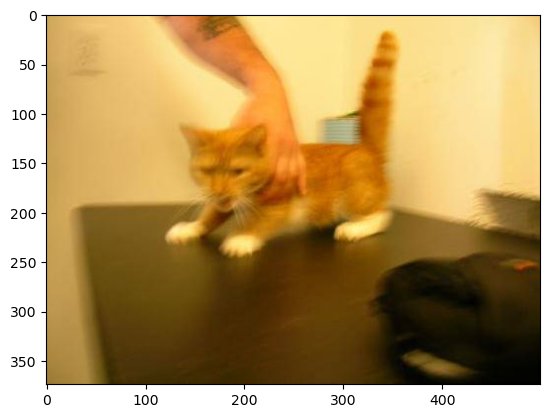

In [ ]:
################################################################################################################################
myf=glob.glob("train/*.jpg")  #load file names of *img type
z=[] #initialize array
all=np.zeros(25000) #initialize labels as all cats
all[12500:25000]=1 #identify dogs

count=0 #initialize counter
for i in myf: #loop through images
    tempname=str("C:/Users/lfult/Documents/DogsCats/"+str(myf[count]))    #get the filename
    tempdata=[all[count],tempname] #place the label and filename in a temporary placeholder
    z.append(tempdata) #append to the initialized z vector
    count+=1 #increase counter
dim1=len(myf) #get the dimension
f=imageio.imread(myf[0]) #plot a sample image
plt.imshow(f)
plt.show()

#do the same for the test data
testfiles=[]
count=0
testf=glob.glob("test/*.jpg")
for j in testf:
    tempname=str("C:/Users/lfult/Documents/DogsCats/"+str(testf[count]))
    testfiles.append(tempname)
    count+=1
################################################################################################################################

## Check Reading from Z and Build Training / Test Sets

(374, 500, 3)


10

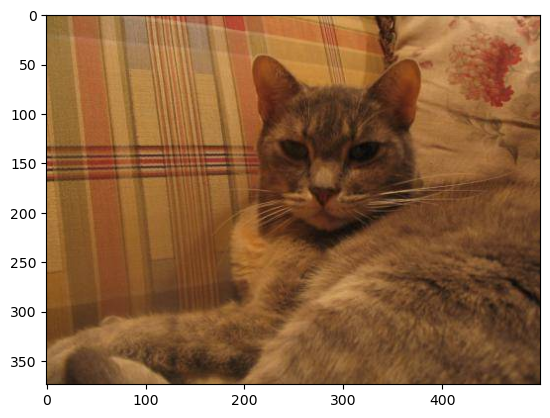

In [ ]:
################################################################################################################################
picnum=12000#pick a random picture
z=pd.DataFrame(z,columns=["label","id"]) #build pandas dataframe with file name and label
testfiles=pd.DataFrame(testfiles, columns=["id"]) #build test dataframe
imshow(plt.imread(z["id"][picnum]),'hot') #demonstrate reading from it
print(plt.imread(z["id"][picnum]).shape) #look at the shape
z['label']=z['label'].astype(str) #convert label to string
random.seed(1234) #random seed
msk = np.random.rand(len(z)) < 0.8 #80% training set, 20% validation set
z1 = z[msk] #training set
z2= z[~msk] #validation set
gc.collect() #clean up
################################################################################################################################

# CNN Module

## Set Up Image Generation / Training & Validation Generators (Very Cool)

In [ ]:
#####################################################Generators###############################################################
reset_keras()
mysize=256 #image size
mybatch=32 #batch size
trainingsteps=np.ceil(20000/mysize)
valsteps=np.ceil(12500/mysize)


random.seed(1234) #let's do this for replicability
with tf.device('/GPU:0'):
        acc=[]      #array for storing validation accuracy
        loss=[]     #array for storing validation loss
        tngacc=[]   #array for storing training accuracy
        tngloss=[]  #array for storing training loss

        #love me some image generation
        aug=ImageDataGenerator(rescale=1./255,
                                 rotation_range=30,
                                 zoom_range=0.2,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 horizontal_flip=False,
                                 fill_mode="nearest")
        #love me some flow from dataframe
        train_generator=aug.flow_from_dataframe(
                                 dataframe=z1,
                                 directory=None,
                                 x_col="id",
                                 y_col="label",
                                 class_mode="categorical",
                                 target_size=(mysize,mysize),
                                 shuffle=True,
                                 batch_size=mybatch,
                                 seed=40)
        #love me a validation set to work with
        val_datagen = ImageDataGenerator(
                                 rescale=1./255)
        #love me some flow from dataframe
        val_generator = val_datagen.flow_from_dataframe(
                                 z2, x_col="id",
                                 y_col="label",
                                 class_mode="categorical",
                                 target_size=(mysize,mysize),
                                 batch_size=mybatch,
                                 seed=41)
        #Gotta' have a test set
        test_datagen = ImageDataGenerator(
                                 rescale=1./255)
        #Love me some flow from dataframe
        test_generator = test_datagen.flow_from_dataframe(
                                testfiles,x_col="id",
                                directory=None,
                                color_mode="rgb",
                                target_size=(mysize,mysize),
                                batch_size=1,
                                class_mode=None,
                                shuffle=False,
                                seed=42)
##############################################################################################################################

Found 19958 validated image filenames belonging to 2 classes.
Found 5042 validated image filenames belonging to 2 classes.
Found 12500 validated image filenames.


In [ ]:
reset_keras()
model=tf.keras.applications.MobileNetV2(
    include_top=False, weights='imagenet', input_tensor=None, input_shape=(mysize,mysize,3),
    pooling=max, classes=2)
x=model.output
x=layers.Flatten()(x)
predictions=layers.Dense(2, activation='softmax')(x)
model = Model(inputs = model.input, outputs = predictions)

# Compile

In [ ]:
##################################################Compile It##################################################################
with tf.device('/GPU:0'):
    model = model
    SGD= tensorflow.keras.optimizers.SGD(lr=0.0001, nesterov=True)
    model.compile(loss=tensorflow.keras.losses.binary_crossentropy,
              optimizer=SGD, metrics=['binary_accuracy'])
    model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 128, 128, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 128, 128, 32  128         ['Conv1[0][0]']                  
                                )                                                             

 block_3_expand_relu (ReLU)     (None, 64, 64, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 65, 65, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 32, 32, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 32, 32, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 16, 16, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 16, 16, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 16, 16, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 16, 16, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 16, 16, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 16, 16, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 16, 16, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 16, 16, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 8, 8, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 8, 8, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 8, 8, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 8, 8, 160)    153600      ['block_14_depthwise_relu[0][0]']


C:\Users\lfult\.conda\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 block_14_project_BN (BatchNorm  (None, 8, 8, 160)   640         ['block_14_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_add (Add)             (None, 8, 8, 160)    0           ['block_13_project_BN[0][0]',    
                                                                  'block_14_project_BN[0][0]']    
                                                                                                  
 block_15_expand (Conv2D)       (None, 8, 8, 960)    153600      ['block_14_add[0][0]']           
                                                                                                  
 block_15_expand_BN (BatchNorma  (None, 8, 8, 960)   3840        ['block_15_expand[0][0]']        
 lization)

In [ ]:
reset_keras()
#model.load_weights('D:/DogsCats/mymod.hdf5')
mysave = tensorflow.keras.callbacks.ModelCheckpoint('C:/Users/lfult/Documents/DogsCats/mymod.hdf5', save_best_only=True, monitor='val_loss', mode='min')


In [ ]:
#####################################################Run the Training#########################################################
with tf.device('/GPU:0'):
    my_train = model.fit(train_generator,
                                 steps_per_epoch=trainingsteps,
                                 epochs=20,
                                 callbacks=[mysave],
                                 validation_data=val_generator
                                 )
model.save('model.h5') #save the model
##############################################################################################################################

Epoch 1/20
79/79 [==============================] - 106s 1s/step - loss: 0.7163 - binary_accuracy: 0.6741 - val_loss: 0.3698 - val_binary_accuracy: 0.8925
Epoch 2/20
79/79 [==============================] - 53s 673ms/step - loss: 0.4620 - binary_accuracy: 0.8240 - val_loss: 0.2399 - val_binary_accuracy: 0.9304
Epoch 3/20
79/79 [==============================] - 54s 688ms/step - loss: 0.3464 - binary_accuracy: 0.8845 - val_loss: 0.1826 - val_binary_accuracy: 0.9451
Epoch 4/20
79/79 [==============================] - 52s 654ms/step - loss: 0.3116 - binary_accuracy: 0.8932 - val_loss: 0.1643 - val_binary_accuracy: 0.9451
Epoch 5/20
79/79 [==============================] - 50s 635ms/step - loss: 0.2858 - binary_accuracy: 0.9066 - val_loss: 0.1412 - val_binary_accuracy: 0.9540
Epoch 6/20
79/79 [==============================] - 47s 597ms/step - loss: 0.2511 - binary_accuracy: 0.9110 - val_loss: 0.1389 - val_binary_accuracy: 0.9530
Epoch 7/20
79/79 [==============================] - 46s 588m

In [ ]:
#####################################################Run the Test Set#########################################################
test_generator.reset() #you have to do this!
pred=model.predict(test_generator,steps=12500,verbose=1) #need to get the forecasts for 12.5K obs
##############################################################################################################################

12500/12500 [==============================] - 121s 10ms/step


In [ ]:
filenames=test_generator.filenames #get the filenames
results=pd.DataFrame({"id":filenames,"label":np.round(pred[:,1],4)})#build a data frame
results.to_csv("results.csv",index=False) #write the results
#You will need to parse the file name from the last '\' and '.jpg'.  Once you do, resort by that value and resave the .csv.
#The easy way to do this is using text_to_columns in Excel.  You can do this in Python as well.
#You can use str.split("\") in pandas as well

# Plot

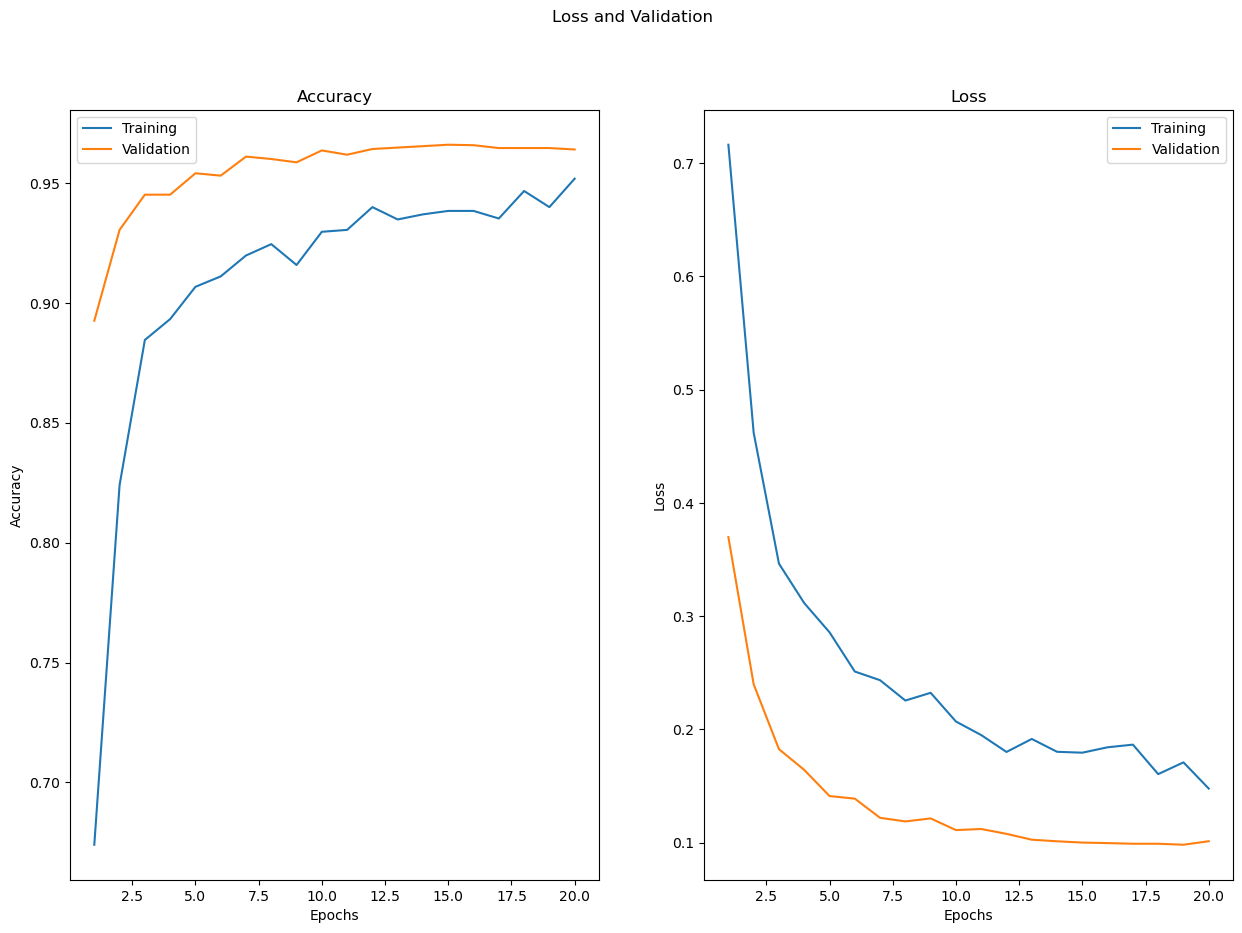

In [ ]:
reset_keras()
def Train_Val_Plot(acc,val_acc,loss,val_loss):

    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle("Loss and Validation")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Training', 'Validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['Training', 'Validation'])
    plt.show()


Train_Val_Plot(my_train.history['binary_accuracy'],my_train.history['val_binary_accuracy'],my_train.history['loss'],my_train.history['val_loss'])